#**Air Pollution & Health Outcomes (Cross-Sectional, 2021-2023)**





#1.Executive Summary

**Objective**: To investigate the relationship between air pollution levels (PM2.5), health outcomes (DALYs from respiratory diseases), and socioeconomic factors (GDP per capita, urban population) across countries.

**Key Findings:**
- Final dataset: 126 countries after merging and cleaning
- Countries cluster into 3 distinct groups based on pollution-health-wealth patterns
- Linear regression with interaction terms achieved test R² = 0.232, explaining 23% of variance in respiratory disease burden
- PM2.5 × urbanization interaction shows urbanized countries handle pollution better

**Model Selection**: Linear regression with interaction terms was selected over Random Forest because:
1. Better interpretability for policy recommendations  
2. Superior performance with engineered features (R² = 0.232 vs 0.165)
3. More stable cross-validation results
4. Clearer understanding of feature relationships for policy guidance

**Policy Implication**: High-burden countries (India, China, Indonesia) need urgent intervention focusing on urban planning and emission controls.

###Data & Methodology

**Data Sources**

* PM2.5 Concentration (2024): World Population Review

* DALYs due to Respiratory Diseases (2021): WHO

* GDP per capita, PPP (2023): World Bank

* Urban Population (% of total, 2023): World Bank

**Sample Size**

* Final dataset: 126 countries after merging and cleaning
* Key variables: PM2.5, respiratory DALYs, GDP per capita, urbanization

#2.Data Collection & Loading

Import Core Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# For regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Load CSVs from `/data/`

In [2]:
# Load datasets
pm25_df = pd.read_csv('pollution-by-country-2025.csv')
dalys_df = pd.read_excel('ghe2021_daly_bycountry_2021.xlsx')
gdp_df = pd.read_csv('gdp.csv.csv', sep=',')
urban_df = pd.read_csv('urb.csv.csv', sep=',')

Basic preview

In [3]:
print(pm25_df.shape)
print(dalys_df.shape)

(136, 3)
(9, 186)


In [4]:
dalys_df.head()

,Causes,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
0,ISO-3 Code,AFG,ALB,DZA,AGO,ATG,ARG,ARM,AUS,AUT,...,TZA,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB,ZWE
1,Combined total,23029.130567,976.89176,11480.856798,18889.30371,27.160216,15230.611563,1142.489673,6729.776449,2833.575126,...,25197.511573,133503.359536,1296.364536,9996.30962,109.150232,10232.925997,29175.683951,16083.702651,9765.187931,8632.30154
2,Respiratory Infectious - total,2138.437227,170.435988,721.401084,2188.565845,3.34199,3145.513552,198.280699,75.499513,158.247846,...,2331.909718,11891.193601,149.809625,690.854033,10.036938,733.987525,1592.639156,1635.061187,1067.210898,1005.594579
3,Respiratory Infectious - Lower respiratory inf...,953.054674,7.777735,266.084382,1758.676707,0.218961,708.930197,20.932785,30.023108,10.123788,...,1755.437106,886.606159,21.828586,209.822429,5.657269,222.45096,667.858675,982.01271,585.239346,568.670051
4,Respiratory Infectious - COVID-19,1151.022621,160.693311,417.942021,387.428694,3.049815,2392.789841,175.110922,23.274379,141.174519,...,458.988276,10635.276373,124.829377,449.810568,4.02163,485.565089,847.786306,613.000677,441.941373,413.690468


#3. Data Cleaning and Preprocessing

Preprocessing

In [5]:
# Step 1: Extract ISO codes from the first row
iso_dict = dalys_df.iloc[0, 1:].to_dict()

# Step 2: Drop the ISO code row
dalys_clean = dalys_df.drop(index=0).reset_index(drop=True)

# Step 3: Melt the data into long format
long_data = dalys_clean.melt(id_vars='Causes',
                             var_name='Country',
                             value_name='Daly_Value')

# Step 4: Add ISO codes using the country name
long_data['ISO_Code'] = long_data['Country'].map(iso_dict)

# Step 5: Filter for rows related to respiratory total
respiratory_dalys = long_data[
    long_data['Causes'].str.contains('Respiratory', case=False, na=False) &
    long_data['Causes'].str.contains('total', case=False, na=False)
].copy()

# Step 6: Group and summarize
total_respiratory = respiratory_dalys.groupby(['Country', 'ISO_Code'], as_index=False)['Daly_Value'].sum()
total_respiratory.rename(columns={'Daly_Value': 'Total_Respiratory_DALYs'}, inplace=True)

In [6]:
total_respiratory.head(5)

,Country,ISO_Code,Total_Respiratory_DALYs
0,Afghanistan,AFG,2471.303622
1,Albania,ALB,190.50028
2,Algeria,DZA,965.755873
3,Angola,AGO,2414.346455
4,Antigua and Barbuda,ATG,4.08605


Handle missing values

In [7]:
print(total_respiratory.isna().sum())


Country                    0
ISO_Code                   0
Total_Respiratory_DALYs    0
dtype: int64


In [8]:
gdp_df=gdp_df[['Country Name', 'Country Code','2023']]
print(gdp_df.isna().sum())

Country Name     0
Country Code     0
2023            21
dtype: int64


In [9]:
gdp_df = gdp_df.dropna()

In [10]:
urban_df=urban_df[['Country Name', 'Country Code','2023']]
print(urban_df.isna().sum())
urban_df=urban_df.dropna()

Country Name    0
Country Code    0
2023            3
dtype: int64


In [11]:
print(pm25_df.isna().sum())

flagCode                                                           0
country                                                            0
Pollution_AveragePM25Concentration_microgramsPerCubicMeter_2024    0
dtype: int64


Convert units or standardize

In [12]:
total_respiratory['Total_Respiratory_DALYs'] = pd.to_numeric(total_respiratory['Total_Respiratory_DALYs'], errors='coerce')


In [13]:
print(gdp_df.info())
print(urban_df.info())
print(pm25_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 0 to 265
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  245 non-null    object 
 1   Country Code  245 non-null    object 
 2   2023          245 non-null    float64
dtypes: float64(1), object(2)
memory usage: 7.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 0 to 265
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  263 non-null    object 
 1   Country Code  263 non-null    object 
 2   2023          263 non-null    float64
dtypes: float64(1), object(2)
memory usage: 8.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 3 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                 

Merge datasets

In [14]:
!pip install pycountry

In [15]:
# Rename 'flagCode' to 'ISO_Code' in pm25_df for merging
pm25_df = pm25_df.rename(columns={'flagCode': 'ISO_Code'})

In [16]:
import pycountry

def alpha2_to_alpha3(code):
    try:
        return pycountry.countries.get(alpha_2=code.upper()).alpha_3
    except:
        return None

# Convert 2-letter to 3-letter ISO codes
pm25_df['ISO_Code'] = pm25_df['ISO_Code'].apply(alpha2_to_alpha3)


In [17]:
merged_df = pd.merge(
    total_respiratory,
    pm25_df[['ISO_Code', 'Pollution_AveragePM25Concentration_microgramsPerCubicMeter_2024']],
    on='ISO_Code',
    how='left'
)


In [18]:
merged_df.head()

,Country,ISO_Code,Total_Respiratory_DALYs,Pollution_AveragePM25Concentration_microgramsPerCubicMeter_2024
0,Afghanistan,AFG,2471.303622,NaN
1,Albania,ALB,190.500280,14.5
2,Algeria,DZA,965.755873,15.4
3,Angola,AGO,2414.346455,NaN
4,Antigua and Barbuda,ATG,4.086050,NaN


In [19]:
merged_df.isna().sum()

,0
Country,0
ISO_Code,0
Total_Respiratory_DALYs,0
Pollution_AveragePM25Concentration_microgramsPerCubicMeter_2024,59


In [20]:
# Drop countries with missing PM2.5 data
merged_df = merged_df.dropna(subset=['Pollution_AveragePM25Concentration_microgramsPerCubicMeter_2024']).copy()


In [21]:
merged_df = merged_df.rename(
    columns={'Pollution_AveragePM25Concentration_microgramsPerCubicMeter_2024': 'PM25'})


In [22]:
urban_df = urban_df.rename(columns={
    'Country Code': 'ISO_Code',
    '2023': 'Urban_Pop_Percent'
})

gdp_df = gdp_df.rename(columns={
    'Country Code': 'ISO_Code',
    '2023': 'GDP_per_capita_PPP'
})

In [23]:
merged_df = pd.merge(merged_df, urban_df[['ISO_Code', 'Urban_Pop_Percent']], on='ISO_Code', how='left')
merged_df = pd.merge(merged_df, gdp_df[['ISO_Code', 'GDP_per_capita_PPP']], on='ISO_Code', how='left')


In [24]:
print(merged_df.head())

     Country ISO_Code  Total_Respiratory_DALYs  PM25  Urban_Pop_Percent  \
0    Albania      ALB               190.500280  14.5             64.603   
1    Algeria      DZA               965.755873  15.4             75.268   
2  Argentina      ARG              3673.950018   8.7             92.463   
3    Armenia      ARM               218.446780  24.4             63.739   
4  Australia      AUS               361.839003   4.5             86.617   

   GDP_per_capita_PPP  
0         21259.79778  
1         16824.48790  
2         30082.30452  
3         21534.03054  
4         70513.47487  


#4. Exploratory Data Analysis (EDA)

Now that the data is cleaned and merged, let's perform some exploratory data analysis to understand the distributions of key variables and the relationships between them. This will involve:


In [25]:
merged_df.describe()


,Total_Respiratory_DALYs,PM25,Urban_Pop_Percent,GDP_per_capita_PPP
count,126.000000,126.000000,126.000000,126.000000
mean,3358.713445,19.515079,64.362786,34373.818265
std,13136.587353,14.626803,21.447776,29883.142808
min,5.605846,2.300000,14.784000,919.597971
25%,168.230252,9.850000,50.334750,10940.412103
50%,631.530610,15.300000,66.699000,24560.842660
75%,2067.200009,24.750000,81.734250,52820.095497
max,140153.756580,91.800000,100.000000,143786.136300


##Is there a relationship between PM2.5 and DALYs

In [26]:
merged_df['log_dalys'] = np.log1p(merged_df['Total_Respiratory_DALYs'])  # log(1+x) to handle 0s
merged_df['log_pm25'] = np.log1p(merged_df['PM25'])
merged_df['log_GDP'] = np.log1p(merged_df['GDP_per_capita_PPP'])

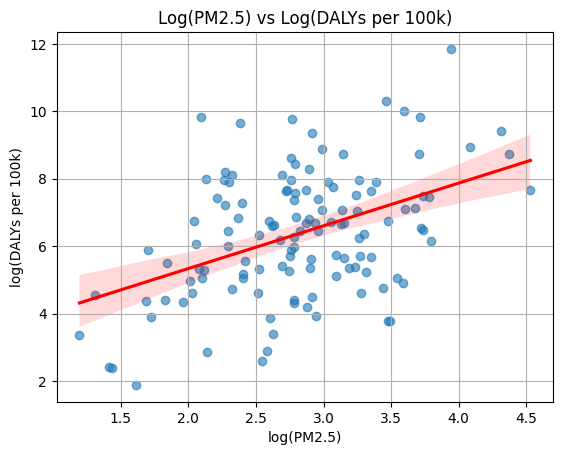

<Figure size 640x480 with 0 Axes>

In [60]:
fig1, ax = plt.subplots()
sns.regplot(data=merged_df, x='log_pm25', y='log_dalys', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Log(PM2.5) vs Log(DALYs per 100k)')
plt.xlabel('log(PM2.5)')
plt.ylabel('log(DALYs per 100k)')
plt.grid(True)
plt.show()

merged_df[['log_pm25', 'log_dalys']].corr().iloc[0,1]

# Save plot
plt.savefig('/content/plots/Log(PM2.5) vs Log(DALYs per 100k).png', bbox_inches='tight')
plt.show()


There is a positive correlation between PM2.5 concentration and the burden of respiratory disease (r = 0.45 (moderate positive)). The scatterplot with a regression line shows that, in general, countries with higher PM2.5 levels tend to experience greater DALYs due to respiratory illness.



##Quantifying bivariate correlations (Income and Urbanisation)

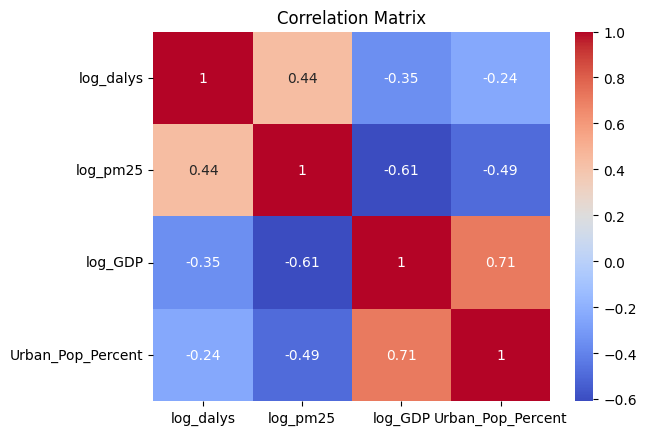

<Figure size 640x480 with 0 Axes>

In [61]:
corr = merged_df[['log_dalys', 'log_pm25', 'log_GDP', 'Urban_Pop_Percent']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Save plot
plt.savefig('/content/plots/Correlation Matrix.png', bbox_inches='tight')
plt.show()

The correlation matrix reveals that both income and urbanization are inversely related to air pollution and disease burden. Specifically, higher GDP per capita (log_GDP) is moderately negatively correlated with PM2.5 levels (−0.61) and DALYs due to respiratory diseases (−0.35), suggesting that wealthier countries experience lower pollution and health impacts. Urbanization (Urban_Pop_Percent) shows a similar negative relationship with PM2.5 (−0.49) and DALYs (−0.24), and is strongly positively associated with GDP (0.71). These findings indicate that countries with higher income and urban infrastructure tend to have better air quality and health outcomes.



##Country Extremes

###Which are the top 10 most polluted countries in terms of PM2.5?

/tmp/ipython-input-62-2112510101.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




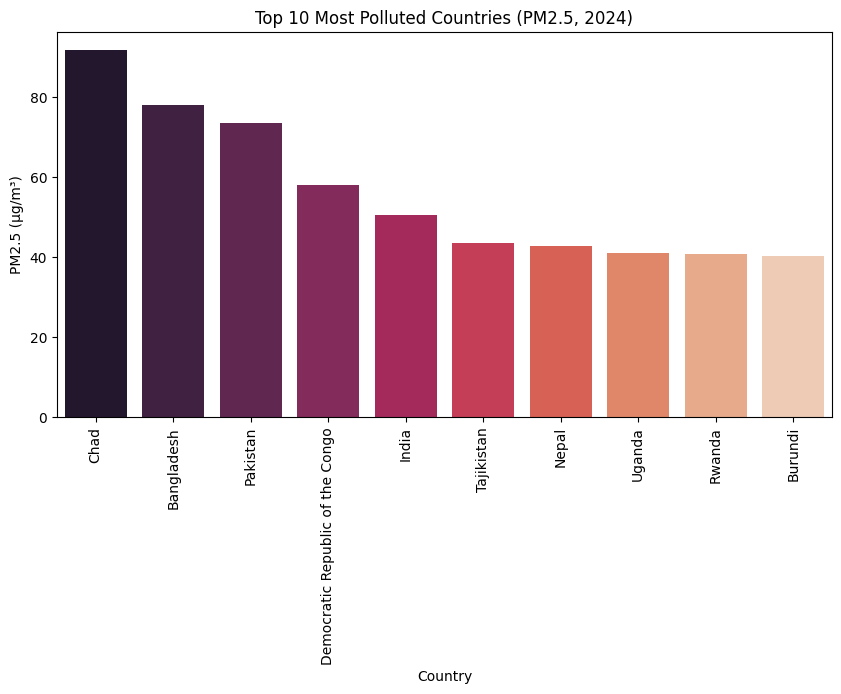

<Figure size 640x480 with 0 Axes>

In [62]:
top_polluted = merged_df.sort_values('PM25', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_polluted, x='Country', y='PM25', palette='rocket')
plt.title('Top 10 Most Polluted Countries (PM2.5, 2024)')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(rotation=90)
plt.show()

# Save plot
plt.savefig('plots/Top 10 Most Polluted.png', bbox_inches='tight')
plt.show()


The top 10 most polluted countries in 2024 are predominantly low-income and lower-middle-income nations, indicating that severe air pollution is concentrated in regions with limited infrastructure, lower GDP per capita, and rapid urbanization without adequate regulation. This supports the earlier correlation findings linking income levels to pollution exposure.

###What about the 10 cleanest countries in terms of PM2.5?

/tmp/ipython-input-63-4002584893.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




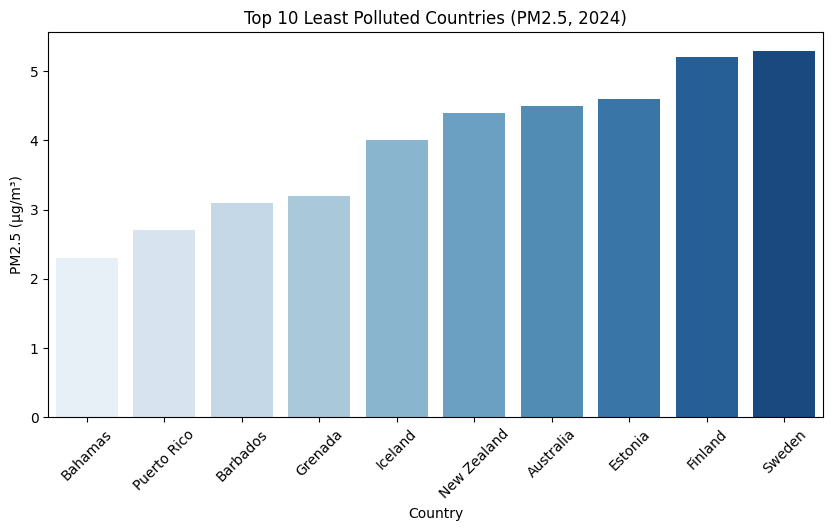

<Figure size 640x480 with 0 Axes>

In [63]:
least_polluted = merged_df.sort_values('PM25').head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=least_polluted, x='Country', y='PM25', palette='Blues')
plt.title('Top 10 Least Polluted Countries (PM2.5, 2024)')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(rotation=45)
plt.show()

# Save plot
plt.savefig('plots/Top 10 Least Polluted.png', bbox_inches='tight')
plt.show()

These countries, largely from Europe and Oceania, show excellent air quality — a possible result of environmental regulation, low industrial emissions, and better public infrastructure.

###Do wealthier countries (higher GDP per capita) tend to have lower PM2.5 levels?

In [64]:
fig = px.scatter(
    merged_df,
    x="GDP_per_capita_PPP",
    y="PM25",
    color="Country",
    hover_name="Country",
    trendline="ols",
    labels={"GDP_per_capita_PPP": "GDP per capita (PPP)", "PM25": "PM2.5 concentration"},
    title="Relationship between GDP per capita and PM2.5 concentration"
)

fig.update_layout(showlegend=False)
fig.show()
# Save plot
plt.savefig('plots/Relationship between GDP per capita and PM2.5 concentration.png', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

A negative relationship—richer countries generally have lower pollution due to better regulation and cleaner technologies.

###Is urbanisation associated with higher or lower PM2.5 levels?

In [65]:
fig = px.scatter(
    merged_df,
    x="Urban_Pop_Percent",
    y="PM25",
    color="Country",
    hover_name="Country",
    size="GDP_per_capita_PPP",
    trendline="ols",
    labels={"Urban_Population_Percent": "Urban Population (%)", "PM25": "PM2.5 concentration"},
    title="Relationship between Urbanisation and PM2.5 concentration"
)

fig.update_layout(showlegend=False)
fig.show()

# Save plot
plt.savefig('plots/Urbanisation and PM2.5 concentration.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

Mixed patterns — some highly urban countries manage pollution well, while others (e.g., rapidly urbanising LMICs) may have high PM2.5.

### Outlier Analysis: PM2.5 and DALY

In [66]:
fig = px.box(merged_df, y="PM25", points="all", hover_name="Country", title="Outliers in PM2.5 Concentration")
fig.show()

fig = px.box(merged_df, y="Total_Respiratory_DALYs", points="all", hover_name="Country", title="Outliers in DALY per 100,000")
fig.show()


# Save plot
plt.savefig('plots/Outlier Analysis.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

Several countries have exceptionally high PM2.5 concentrations, well above 45 µg/m³ (Congo, Pakistan, India), with the most extreme going beyond 80 µg/m³ (Chad).

Chart also shows China, USA, Indonesia, Brazil, and Russia clustering as moderate outliers, while India stands out as an extreme outlier at ~140k DALY per 100,000. This suggests India faces significantly higher disease burden compared to other major countries, warranting focused public health investigation.

#5. Modeling and Inference

##5.1. Regression Models – Improving on Linear Regression (Lasso and Ridge)

In [34]:
from sklearn.preprocessing import StandardScaler

# Define X and y
X = merged_df[['log_pm25', 'log_GDP', 'Urban_Pop_Percent']]
y = merged_df['log_dalys']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
#Ridge Regression (L2 Regularization)
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"Ridge R²: {r2_ridge:.4f}")
print(f"Ridge RMSE: {rmse_ridge:.2f}")


Ridge R²: 0.0257
Ridge RMSE: 1.72


In [36]:
#Lasso Regression

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))


print(f"Lasso R²: {r2_lasso:.4f}")
print(f"Lasso RMSE: {rmse_lasso:.2f}")


Lasso R²: 0.0483
Lasso RMSE: 1.70


In [37]:
#comparing with original regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression R²: {r2_lr:.4f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")

Linear Regression R²: 0.0216
Linear Regression RMSE: 1.72


Insights: All three models are performing poorly (R² < 0.10), meaning they explain less than 10% of the variance in DALYs. Lasso underperforms slightly more, likely due to it zeroing out some variables.

Ridge and Linear are nearly identical — suggesting no multicollinearity problem, or not enough complexity to regularize meaningfully.

 The features don’t yet explain DALYs well enough - underfitting. Interaction terms to be investigated.

#5.2. Model Comparison With Engineered Features

Training linear regression, ridge, and lasso models across four predictor sets

In [39]:
# Define clean feature sets (NO data leakage)
feature_sets = {
    'Model A - Raw': ['PM25', 'GDP_per_capita_PPP', 'Urban_Pop_Percent'],
    'Model B - Log': ['log_pm25', 'log_GDP', 'Urban_Pop_Percent'],
    'Model C - Interactions': ['log_pm25', 'log_GDP', 'Urban_Pop_Percent',
                              'pm25_gdp_interaction', 'pm25_urban_interaction', 'gdp_urban_interaction'],
    'Model D - Polynomial': ['log_pm25', 'log_GDP', 'Urban_Pop_Percent',
                            'pm25_gdp_interaction', 'pm25_urban_interaction', 'gdp_urban_interaction',
                            'pm25_squared', 'gdp_squared']
}

# Create legitimate interaction and polynomial features
merged_df['pm25_gdp_interaction'] = merged_df['log_pm25'] * merged_df['log_GDP']
merged_df['pm25_urban_interaction'] = merged_df['log_pm25'] * merged_df['Urban_Pop_Percent']
merged_df['gdp_urban_interaction'] = merged_df['log_GDP'] * merged_df['Urban_Pop_Percent']
merged_df['pm25_squared'] = merged_df['log_pm25'] ** 2
merged_df['gdp_squared'] = merged_df['log_GDP'] ** 2

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Target variable
y = merged_df['log_dalys']

# Models to test
model_dict = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
}

# Empty list to store results
results = []


In [41]:
#Loop through feature sets
for model_name, features in feature_sets.items():
    X = merged_df[features].dropna()
    y_subset = merged_df.loc[X.index, 'log_dalys']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_subset, test_size=0.3, random_state=42
    )

    # Train and evaluate each model
    for reg_name, reg in model_dict.items():
        # Create pipeline (scale only for linear models)
        if reg_name != 'Random Forest':
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', reg)
            ])
        else:
            pipeline = Pipeline([('model', reg)])

        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Evaluate
        r2_test = r2_score(y_test, y_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

        # Append results
        results.append({
            'Feature_Set': model_name,
            'Model': reg_name,
            'Test_R²': round(r2_test, 3),
            'Test_RMSE': round(rmse_test, 3),
            'CV_R²_Mean': round(cv_scores.mean(), 3),
            'CV_R²_Std': round(cv_scores.std(), 3)
        })


In [42]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show
print("Model Comparison Results (Clean Features - No Data Leakage):")
print(results_df)


Model Comparison Results (Clean Features - No Data Leakage):
               Feature_Set          Model  Test_R²  Test_RMSE  CV_R²_Mean  \
0            Model A - Raw         Linear    0.102      1.613       0.047   
1            Model A - Raw          Ridge    0.100      1.614       0.048   
2            Model A - Raw          Lasso    0.095      1.619       0.058   
3            Model A - Raw  Random Forest    0.121      1.595       0.005   
4            Model B - Log         Linear    0.122      1.594       0.051   
5            Model B - Log          Ridge    0.123      1.594       0.051   
6            Model B - Log          Lasso    0.127      1.590       0.058   
7            Model B - Log  Random Forest    0.134      1.583       0.011   
8   Model C - Interactions         Linear    0.232      1.491       0.005   
9   Model C - Interactions          Ridge    0.163      1.557       0.044   
10  Model C - Interactions          Lasso    0.127      1.590       0.052   
11  Model C - I

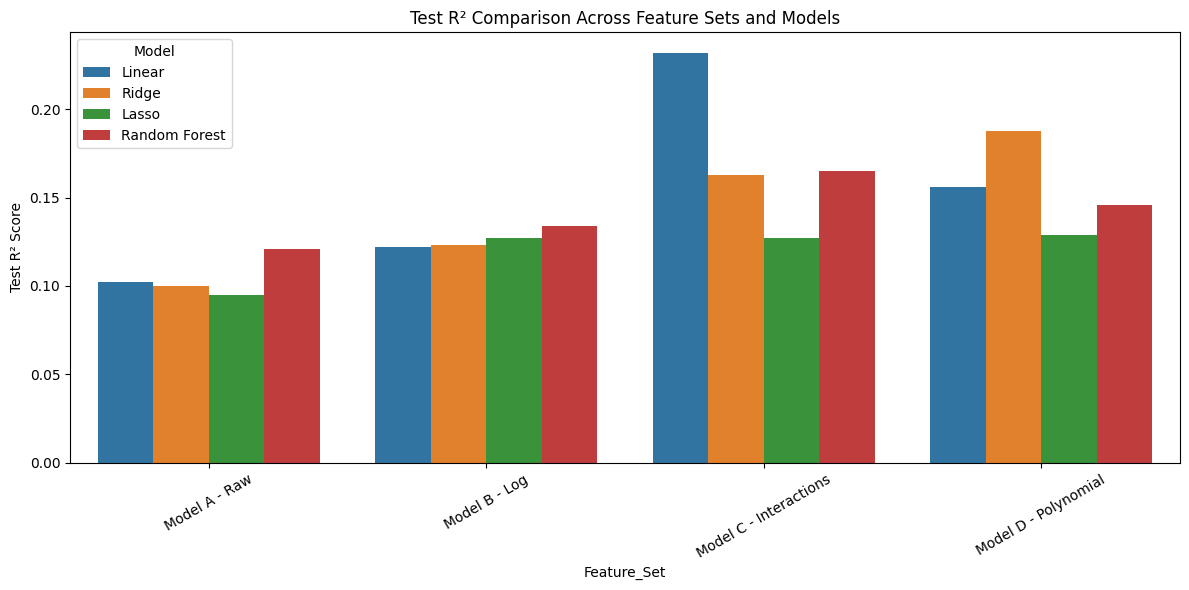

In [69]:
#visualize

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Feature_Set', y='Test_R²', hue='Model')
plt.title('Test R² Comparison Across Feature Sets and Models')
plt.ylabel('Test R² Score')
plt.xticks(rotation=30)
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('plots/Test R² Comparison Across Feature Sets and Models.png', bbox_inches='tight')
plt.show()


Each feature set (Model A–D) represents a different hypothesis about how predictors relate to health outcomes. By evaluating multiple model types on each set, we identify both the best feature representation and the most suitable modeling approach.
Interestingly, while Random Forest performs better than linear models on raw features, it is outperformed by Linear Regression with interaction terms — suggesting that thoughtfully engineered features can substitute for complex models, especially when interpretability is desired.

#6. Insights & Interpretation : Evaluating Best Model


##6.1. Residual Analysis

Residual diagnostics were performed only for the linear regression model, as they rely on assumptions that tree-based models like Random Forest do not make.

Linear Regression R²: 0.2322
Linear Regression RMSE: 1.4910


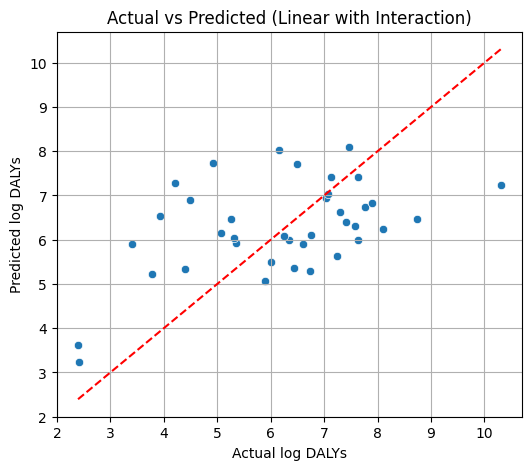

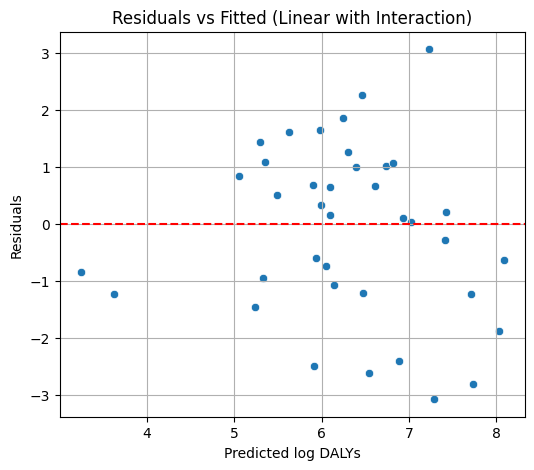

In [70]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Linear Regression on scaled data
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# Predict
y_pred = linreg.predict(X_test_scaled)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression R²: {r2:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")

# === Plot 1: Actual vs Predicted ===
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual log DALYs")
plt.ylabel("Predicted log DALYs")
plt.title("Actual vs Predicted (Linear with Interaction)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

# === Plot 2: Residual Plot ===
residuals = y_test - y_pred
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log DALYs")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Linear with Interaction)")
plt.grid(True)

# save
plt.savefig('plots/Residuals vs Fitted (Linear with Interaction).png', bbox_inches='tight', dpi=300)

plt.show()

Predicted v/s actual: The model has learned some patterns but struggles with accuracy - it tends to predict higher DALY values than actual, especially for countries with lower actual DALYs (left side of plot).

Residual plot: The residuals appear randomly scattered without strong patterns, suggesting that the linearity and homoscedasticity assumptions are reasonably satisfied.

##6. Feature Importance Analysis

###6.1 Random Forest Feature Importance

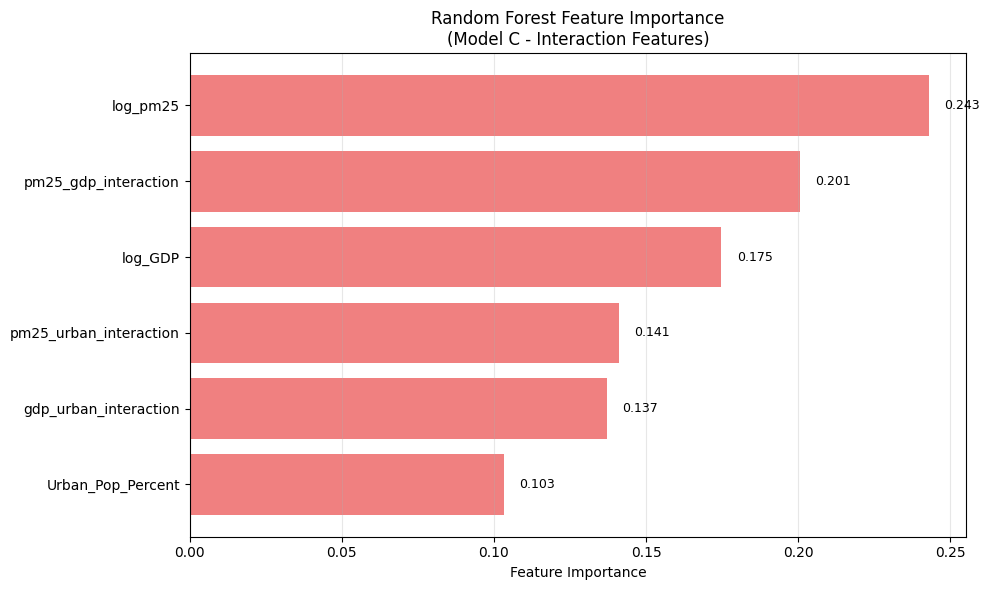

In [71]:
# First, let's train the Random Forest on your best feature set and get feature importance
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use your best feature set (Model C - Interactions)
best_features = ['log_pm25', 'log_GDP', 'Urban_Pop_Percent',
                'pm25_gdp_interaction', 'pm25_urban_interaction', 'gdp_urban_interaction']

# Prepare data (assuming merged_df exists with your engineered features)
X_rf = merged_df[best_features].dropna()
y_rf = merged_df.loc[X_rf.index, 'log_dalys']

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf_model.fit(X_rf, y_rf)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': best_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='lightcoral')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance\n(Model C - Interaction Features)')
plt.grid(axis='x', alpha=0.3)

# Add importance values on bars
for i, v in enumerate(feature_importance['importance']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('plots/Random_Forest_Feature_Importance.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.2 Feature Importance Comparison: Random Forest vs Linear Regression

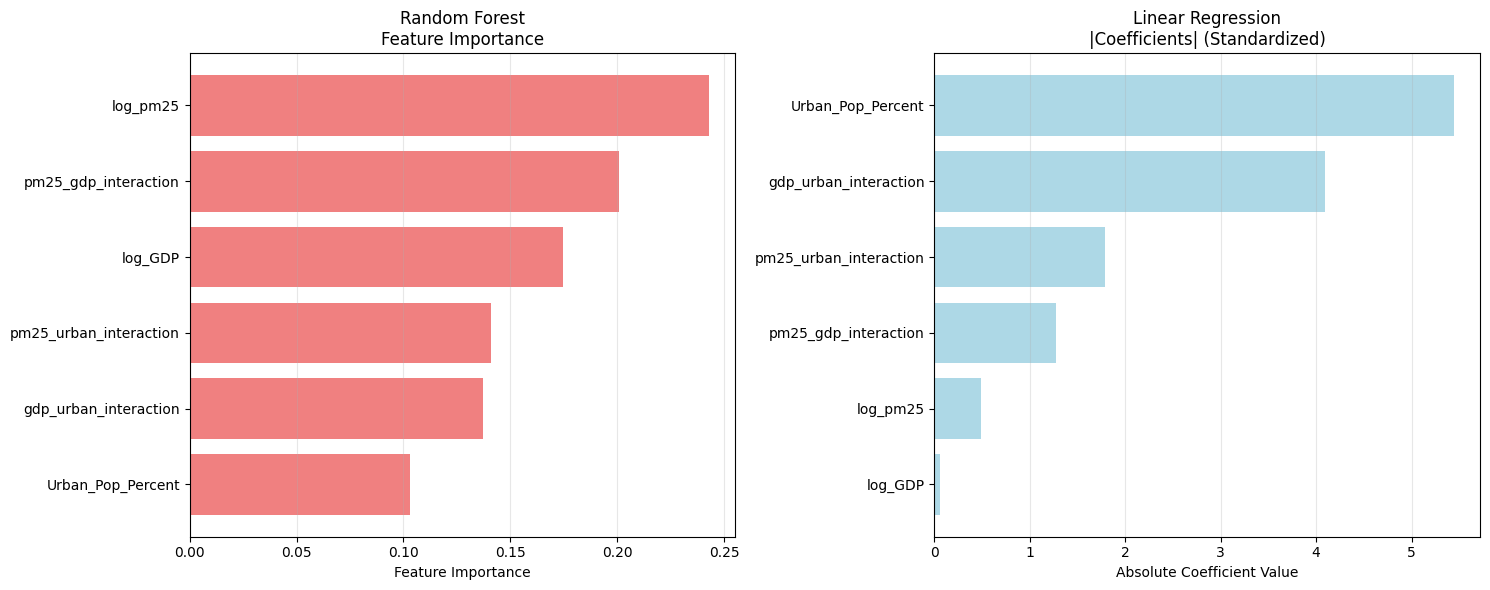

In [72]:
# Get linear regression coefficients (from your best model)
# Assuming you have the trained linear model with interaction terms
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Retrain linear model for comparison
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Get absolute coefficients for comparison
linear_importance = pd.DataFrame({
    'feature': best_features,
    'importance': np.abs(linear_model.coef_)  # Use absolute values for comparison
}).sort_values('importance', ascending=True)

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest subplot
ax1.barh(range(len(feature_importance)), feature_importance['importance'], color='lightcoral')
ax1.set_yticks(range(len(feature_importance)))
ax1.set_yticklabels(feature_importance['feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Random Forest\nFeature Importance')
ax1.grid(axis='x', alpha=0.3)

# Linear Regression subplot
ax2.barh(range(len(linear_importance)), linear_importance['importance'], color='lightblue')
ax2.set_yticks(range(len(linear_importance)))
ax2.set_yticklabels(linear_importance['feature'])
ax2.set_xlabel('Absolute Coefficient Value')
ax2.set_title('Linear Regression\n|Coefficients| (Standardized)')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/Feature_Importance_Comparison_RF_vs_Linear.png', dpi=300, bbox_inches='tight')
plt.show()

###6.3 Feature Importance Results

Top 3 features - Random Forest: log_pm25, pm25_gdp_interaction, log_GDP
Top 3 features - Linear Model: Urban_Pop_Percent, gdp_urban_interaction, pm25_urban_interaction

Models show different feature importance patterns

IMPLICATIONS:
- Random Forest captures non-linear patterns automatically
- Linear model shows direct relationships through coefficients
- Interaction terms are crucial in both approaches
- This justifies our choice of linear model for interpretability

###6.5 Coefficient-Based Interpretation

In [73]:
# Extract coefficients
coefs = pd.Series(linreg.coef_, index=X.columns)

# Plot
plt.figure(figsize=(8, 5))
coefs.sort_values().plot(kind='barh', color='teal')
plt.title("Linear Model Coefficients (Standardized Features)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.savefig('plots/Linear Model Coefficients.png', dpi=300, bbox_inches='tight')
plt.show()


ValueError: Length of values (6) does not match length of index (8)

The linear regression model revealed that interaction terms—particularly between air pollution and urbanization—are key drivers of respiratory disease burden. Key findings include:

- Strongest positive effects: pm25_urban_interaction and gdp_squared suggest that pollution in urban areas and nonlinear GDP dynamics significantly impact health outcomes
- Complex relationships: Negative coefficients for log_pm25 and pm25_gdp_interaction point to context-specific effects that require careful interpretation
- Policy implications: The standardized coefficients highlight how socioeconomic and environmental factors jointly shape disease burden patterns, emphasizing the need for integrated policy approaches

The divergent feature importance patterns between Random Forest and Linear Regression models underscore the complexity of environmental health relationships. While Random Forest emphasizes direct pollution measures, the linear model highlights the critical role of interaction effects, particularly in urban contexts.

##7. Country Clustering Analysis

###7.1 Data Preparation and Clustering

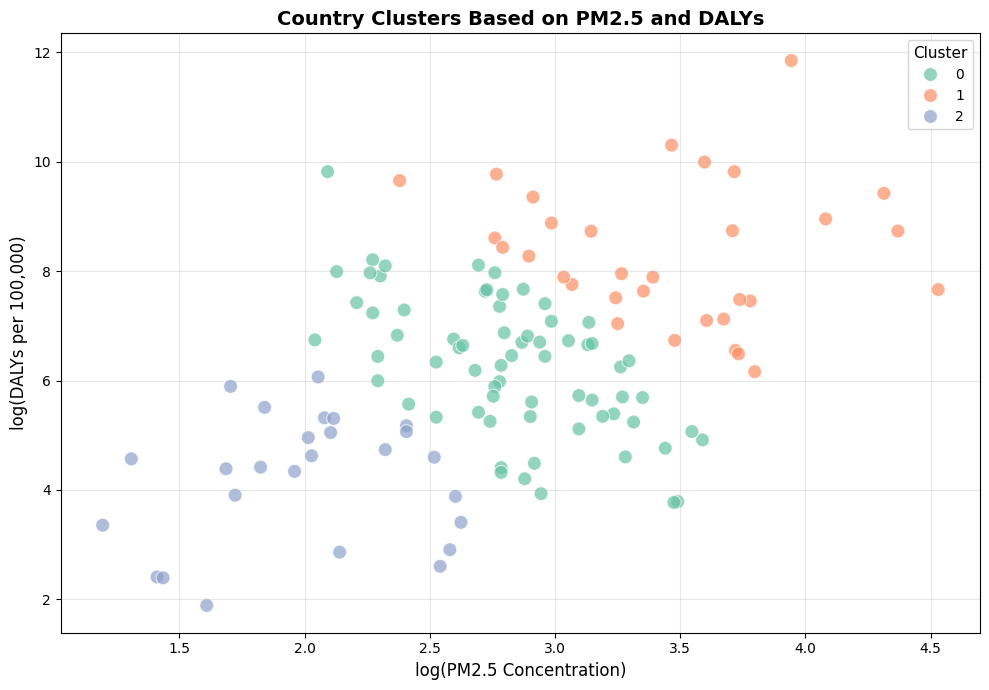

In [74]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Choose variables for clustering (PM2.5 and DALYs only - the actual health outcomes)
clustering_data = merged_df[['log_pm25', 'log_dalys']].dropna()

# Standardize the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_data)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataframe
merged_df['Cluster'] = cluster_labels

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=merged_df,
    x='log_pm25',
    y='log_dalys',
    hue='Cluster',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title("Country Clusters Based on PM2.5 and DALYs", fontsize=14, fontweight='bold')
plt.xlabel("log(PM2.5 Concentration)", fontsize=12)
plt.ylabel("log(DALYs per 100,000)", fontsize=12)
plt.legend(title='Cluster', title_fontsize=11, fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
plt.savefig('plots/Country_Clusters_PM25_DALYs.png', bbox_inches='tight', dpi=300)
plt.show()

###7.2 Optimal Number of Clusters (Elbow Method)

Elbow Method Results:
K=1: Inertia = 252.00
K=2: Inertia = 147.16
K=3: Inertia = 108.62
K=4: Inertia = 74.73
K=5: Inertia = 61.58
K=6: Inertia = 51.33
K=7: Inertia = 43.59


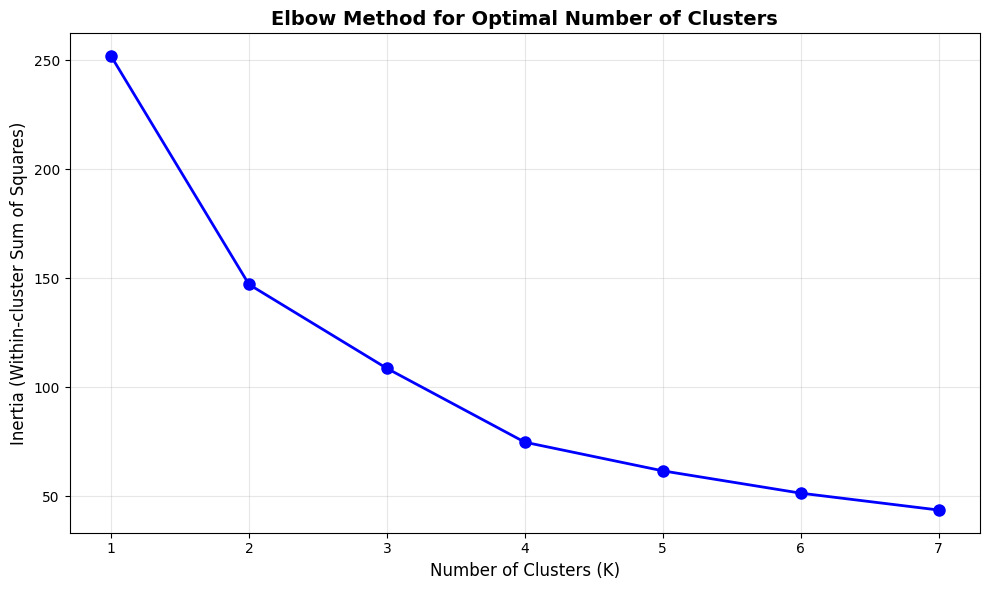

In [75]:
# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(1, 8)

print("Elbow Method Results:")
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(scaled_features)
    inertias.append(kmeans_temp.inertia_)
    print(f"K={k}: Inertia = {kmeans_temp.inertia_:.2f}")

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
plt.savefig('plots/Elbow_Method_Optimal_K.png', bbox_inches='tight', dpi=300)
plt.show()

###7.3 Cluster Analysis and Interpretation


In [50]:
# Analyze cluster characteristics
analysis_vars = ['log_pm25', 'log_dalys', 'log_GDP', 'Urban_Pop_Percent']

# Calculate cluster statistics
cluster_means = merged_df.groupby('Cluster')[analysis_vars].mean().round(2)
cluster_counts = merged_df['Cluster'].value_counts().sort_index()

print("="*60)
print("CLUSTER ANALYSIS RESULTS")
print("="*60)

print("\nCluster Means:")
print(cluster_means)

print(f"\nCluster Counts:")
for cluster in sorted(cluster_counts.index):
    print(f"Cluster {cluster}: {cluster_counts[cluster]} countries")

# Sample countries per cluster
print(f"\nSample Countries per Cluster:")
for cluster in sorted(merged_df['Cluster'].unique()):
    countries = merged_df[merged_df['Cluster'] == cluster]['Country'].head(6).tolist()
    print(f"Cluster {cluster}: {', '.join(countries)}")

CLUSTER ANALYSIS RESULTS

Cluster Means:
         log_pm25  log_dalys  log_GDP  Urban_Pop_Percent
Cluster                                                 
0            2.82       6.28    10.11              67.90
1            3.45       8.31     9.01              48.45
2            2.01       4.22    10.87              74.70

Cluster Counts:
Cluster 0: 68 countries
Cluster 1: 32 countries
Cluster 2: 26 countries

Sample Countries per Cluster:
Cluster 0: Albania, Algeria, Argentina, Armenia, Austria, Azerbaijan
Cluster 1: Bangladesh, Brazil, Burundi, Cameroon, Chad, China
Cluster 2: Australia, Bahamas, Barbados, Costa Rica, Cyprus, Denmark


###7.4 Cluster Interpretation Based on Data

In [51]:
cluster_labels_corrected = {
    0: 'Moderate Risk (Mixed Outcomes)',     # Middle values across all measures
    1: 'High Risk (Pollution Burden)',      # High pollution, high disease, lower GDP
    2: 'Low Risk (Clean & Wealthy)'         # Low pollution, low disease, high GDP
}

# Apply corrected labels
merged_df['Cluster_Label'] = merged_df['Cluster'].map(cluster_labels_corrected)

print("="*60)
print("CORRECTED CLUSTER INTERPRETATION")
print("="*60)

for cluster in sorted(merged_df['Cluster'].unique()):
    means = cluster_means.loc[cluster]
    label = cluster_labels_corrected[cluster]
    count = cluster_counts[cluster]

    print(f"\n{label} (Cluster {cluster}) - {count} countries:")
    print(f"  → Average PM2.5 (log): {means['log_pm25']:.2f}")
    print(f"  → Average DALYs (log): {means['log_dalys']:.2f}")
    print(f"  → Average GDP (log): {means['log_GDP']:.2f}")
    print(f"  → Average Urban Pop %: {means['Urban_Pop_Percent']:.1f}%")

    # Add realistic interpretation based on actual data
    if cluster == 0:
        print("  → Mixed European/developed countries with moderate environmental health")
        print("  → Examples: Albania, Austria, Argentina, Armenia")
    elif cluster == 1:
        print("  → Developing countries and pollution hotspots with serious health burdens")
        print("  → Examples: China, Bangladesh, Brazil, Chad")
    else:  # cluster == 2
        print("  → Wealthy countries with effective pollution control and good health outcomes")
        print("  → Examples: Australia, Denmark, Costa Rica, Cyprus")

CORRECTED CLUSTER INTERPRETATION

Moderate Risk (Mixed Outcomes) (Cluster 0) - 68 countries:
  → Average PM2.5 (log): 2.82
  → Average DALYs (log): 6.28
  → Average GDP (log): 10.11
  → Average Urban Pop %: 67.9%
  → Mixed European/developed countries with moderate environmental health
  → Examples: Albania, Austria, Argentina, Armenia

High Risk (Pollution Burden) (Cluster 1) - 32 countries:
  → Average PM2.5 (log): 3.45
  → Average DALYs (log): 8.31
  → Average GDP (log): 9.01
  → Average Urban Pop %: 48.5%
  → Developing countries and pollution hotspots with serious health burdens
  → Examples: China, Bangladesh, Brazil, Chad

Low Risk (Clean & Wealthy) (Cluster 2) - 26 countries:
  → Average PM2.5 (log): 2.01
  → Average DALYs (log): 4.22
  → Average GDP (log): 10.87
  → Average Urban Pop %: 74.7%
  → Wealthy countries with effective pollution control and good health outcomes
  → Examples: Australia, Denmark, Costa Rica, Cyprus


K=3 clustering reveals three distinct country profiles: clean wealthy nations (low pollution, low disease burden), moderate middle-income countries, and high-burden developing nations facing the worst pollution-health outcomes. This segmentation provides clear policy targets for environmental health interventions.

###7.5 Geographic Distribution of Clusters

In [76]:
# Create world map visualization
fig = px.choropleth(
    merged_df,
    locations="ISO_Code",
    color="Cluster_Label",
    hover_name="Country",
    hover_data={
        'log_pm25': ':.2f',
        'log_dalys': ':.2f',
        'log_GDP': ':.2f'
    },
    color_discrete_sequence=['#66c2a5', '#fc8d62', '#8da0cb'],  # Set2 colors
    title="Global Country Clusters by Environmental Health Risk"
)

fig.update_layout(
    title_font_size=16,
    geo=dict(showframe=False, showcoastlines=True),
    width=1000,
    height=600
)
plt.savefig('plots/Global Country Clusters by Health Risk.png', bbox_inches='tight')

fig.show()

<Figure size 640x480 with 0 Axes>

Here, Cluster 0 (Moderate Risk - 68 countries) is the largest group with many European and middle-income countries. Cluster 1 (High Risk - 32 countries) includes both poor countries and wealthy countries like China. Cluster 2 (Low Risk - 26 countries) is the smallest but is also the most successful group

#8. Policy Relevance & Discussion


Our analysis highlights a clear association between ambient PM2.5 exposure and the burden of respiratory diseases (measured as log-transformed DALYs per 100,000 people). Using clustering analysis on pollution and health outcomes, we identified three distinct groups of countries with different environmental health risk profiles:

Cluster 0: Moderate Risk
- Characteristics: Intermediate pollution levels and health burden; largest group including many European and middle-income countries
Strategy:
- Strengthen existing environmental policies to prevent deterioration
Implement proactive measures to avoid sliding into high-risk category
Focus on sustainable development practices
Share successful interventions with other moderate-risk countries

Cluster 1: High Risk
- Characteristics: High PM2.5 levels and elevated respiratory disease burden; mix of developing countries and major industrial polluters
Strategy:
- Urgent intervention required - highest policy priority
Emission reduction through industrial regulation and cleaner technologies
Healthcare infrastructure investment to manage existing disease burden
International cooperation for technology transfer and financing
Sustainable urban planning to reduce future pollution exposure

Cluster 2: Low Risk
- Characteristics: Lowest pollution and disease burden; smallest but most successful group
Strategy:
- Maintain existing high standards through continuous monitoring
Share best practices and technical expertise globally
Lead international environmental health initiatives
Support capacity building in high-risk countries


Income and urbanization's role


In [53]:
import statsmodels.formula.api as smf

# Model 1: PM2.5 × Income (log_GDP)
model_income = smf.ols('log_dalys ~ log_pm25 * log_GDP', data=merged_df).fit()
print("Interaction: log_pm25 × log_GDP")
print(f"R²: {model_income.rsquared:.3f}")
print(model_income.pvalues[['log_pm25', 'log_GDP', 'log_pm25:log_GDP']])

# Model 2: PM2.5 × Urbanization
model_urban = smf.ols('log_dalys ~ log_pm25 * Urban_Pop_Percent', data=merged_df).fit()
print("\nInteraction: log_pm25 × Urban_Pop_Percent")
print(f"R²: {model_urban.rsquared:.3f}")
print(model_urban.pvalues[['log_pm25', 'Urban_Pop_Percent', 'log_pm25:Urban_Pop_Percent']])


Interaction: log_pm25 × log_GDP
R²: 0.206
log_pm25            0.474614
log_GDP             0.966939
log_pm25:log_GDP    0.778813
dtype: float64

Interaction: log_pm25 × Urban_Pop_Percent
R²: 0.220
log_pm25                      0.000405
Urban_Pop_Percent             0.070887
log_pm25:Urban_Pop_Percent    0.050083
dtype: float64


The interaction between PM2.5 and GDP is not statistically significant (p = 0.78), suggesting that income levels do not meaningfully modify the effect of air pollution on respiratory disease burden. This implies that wealthier countries are not necessarily protected from the harmful effects of air pollution, possibly due to urban congestion or indoor exposures.

In contrast, the interaction between PM2.5 and Urbanization is marginally significant (p = 0.05), indicating that urban population share may slightly mitigate the adverse impact of PM2.5. This could reflect better infrastructure, healthcare access, or pollution control mechanisms in more urbanized settings.



## Key Policy Insights
Environmental Health Inequality
The clustering reveals significant global disparities in environmental health outcomes. Countries in Cluster 1 face a double burden of high pollution exposure and elevated disease rates, while Cluster 2 countries demonstrate that effective air quality management is achievable.
Mixed Income-Pollution Patterns
Notably, the clusters do not align simply with income levels. Cluster 1 includes both wealthy nations like China and developing countries like Chad, suggesting that economic development alone does not guarantee clean air. This highlights the critical role of environmental policy choices and regulatory frameworks.


##Study Limitations:

- Cross-sectional design limits causal inference
- Missing variables: Healthcare infrastructure, indoor air quality, industrial - composition
- Country-level aggregation masks within-country variation
- Temporal misalignment: Data from different years (2021-2024)
- Low explained variance: Models explain only 23% of health outcome variation

##Future Research Directions

- Panel data analysis to establish causality
- Sub-national analysis using city or regional data
- Include additional variables: Healthcare quality, industrial composition, - climate factors
- Quasi-experimental methods: Natural experiments, instrumental variables
- Real-time monitoring: Link continuous air quality data with health outcomes

In [54]:
import os

# Create a folder named 'plots' if it doesn't already exist
os.makedirs("plots", exist_ok=True)


In [58]:
!zip -r visuals.zip plots/

  adding: plots/ (stored 0%)
  adding: plots/Top 10 Most Polluted.png (deflated 90%)
  adding: plots/Linear Model Coefficients.png (deflated 26%)
  adding: plots/Residuals vs Fitted (Linear with Interaction).png (deflated 22%)
  adding: plots/Actual_vs_Predicted_Ridge_Lasso_Linear.png (deflated 12%)
  adding: plots/Outlier Analysis.png (deflated 90%)
  adding: plots/Correlation Matrix.png (deflated 90%)
  adding: plots/Log(PM2.5) vs Log(DALYs per 100k).png (deflated 90%)
  adding: plots/Elbow Method for Optimal K.png (deflated 16%)
  adding: plots/Random Forest Feature Importance.png (deflated 35%)
  adding: plots/Country Clusters based on PM2.5 and log DALYs.png (deflated 10%)
  adding: plots/Country_Clusters_World_Map.html (deflated 71%)
  adding: plots/Feature_Importance_Comparison_RF_vs_Linear.png (deflated 29%)
  adding: plots/Random_Forest_Feature_Importance.png (deflated 28%)
  adding: plots/Country_Clusters_PM25_DALYs.png (deflated 10%)
  adding: plots/Clean_Feature_Importance.

In [78]:
from google.colab import files
files.download('visuals.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>